# **Trabajo Práctico Final**: Linear/Quadratic Discriminant Analysis (LDA/QDA)
___________________________________________________________________________
##*Analísis Mátematico para Inteligencia Artificial*                                   
##*Facultad de Ingeniería de la Universidad de Buenos Aires*                                                 
##*B. Masso, J. D. Canal, J. C. Ferreyra,S. Rodríguez, Y. P. Arrieta Echavez*


---




# 1 Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


***Resolución***

---

##***Definición herramientas***

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import det, inv
from sklearn.datasets import load_iris, fetch_openml
from sklearn.model_selection import train_test_split

class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)


class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

In [2]:
# hiperparámetros
rng_seed = 6543

In [3]:
#Descarga de datos

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True)

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

In [4]:
# preparing data, train - test validation
# 70-30 split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

## ***1.1 Punto 1***

In [5]:
def try_prioris(X, y, random_seed, a_prioris, classf, data):
  train_x, train_y, test_x, test_y = split_transpose(X, y, 0.4, random_seed)

  if classf == 'QDA':
    print("QDA")
    M = QDA()
  else:
    print("LDA")
    M = LDA()

  # Iterate over each priori distribution and save results in a dataframe.
  results = []
  for k, a_priori in a_prioris.items():
    M.fit(train_x, train_y, a_priori=a_priori)
    acc_train = accuracy(train_y, M.predict(train_x))
    acc_test = accuracy(test_y, M.predict(test_x))

    res = {
      "Modelo": classf,
      "Dataset": data,
      "Seed": random_seed,
      "Priori":k,
      "Error(Train)":1-acc_train,
      "Error(Test)":1-acc_test
    }

    test_y_encoded = M.encoder.transform(test_y)

    for class_id in range(len(M.encoder.names)):
      mask = test_y_encoded == class_id
      acc_class = accuracy(test_y[:, mask.flatten()], M.predict(test_x[:, mask.flatten()]))
      res[f"ErrorClase{class_id}"] = 1-acc_class

    results.append(res)

  df_results = pd.DataFrame(results)

  return df_results

In [6]:
# Descargamos los datos de iris dataset y spliteamos en train y test
random_seed = 42

a_prioris = {
    "sin_priori" : None,
    "uniforme" : [(1/3), (1/3), (1/3)],
    "clase0_90": [.9, .05, .05],
    "clase1_90": [.05, .9, .05],
    "clase2_90": [.05, .05, .9]
}

In [7]:
X_full, y_full = get_iris_dataset()

try_prioris(X_full, y_full, random_seed, a_prioris, 'QDA','Iris')

QDA


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Iris,42,sin_priori,0.011111,0.016667,0.0,0.000000,0.055556
1,QDA,Iris,42,uniforme,0.011111,0.016667,0.0,0.000000,0.055556
2,QDA,Iris,42,clase0_90,0.011111,0.016667,0.0,0.000000,0.055556
3,QDA,Iris,42,clase1_90,0.044444,0.050000,0.0,0.000000,0.166667
4,QDA,Iris,42,clase2_90,0.044444,0.016667,0.0,0.052632,0.000000


In [8]:
# Observamos cuál es la distribución del dataset completo.
encoder = ClassEncoder()

y_full_encoded = encoder.fit_transform(y_full)
original_distribution = np.bincount(y_full_encoded.flatten().astype(int)) / y_full_encoded.size

print("\nDistribución original: ", original_distribution)


Distribución original:  [0.33333333 0.33333333 0.33333333]


Observamos que la distribución probabilística del dataset original es de 1/3 para cada clase. Por este motivo la priori uniforme otorga resultados consistentes con la priori calculada sobre el train set (aunque al splitearse de manera aleatoria puede variar su distribución, esta tiende a parecerse a una uniforme).

Resulta interesante notar que la clase 2 ("virginica") es causante de los mayores errores de predicción, posiblemente por solapamiento con las otras clases en los features utilizados. Sin embargo, al seleccionar la priori en dónde la clase 2 posee probabilidad 0.9, el error en esa clase desaparece y se traslada a una de las otras clases.



## ***1.2 Punto 2***

In [9]:
# Descargamos los datos de penguin dataset y spliteamos en train y test
X_full, y_full = get_penguins()

try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Penguins")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


QDA


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Penguins,42,sin_priori,0.009756,0.007299,0.015625,0.000000,0.0
1,QDA,Penguins,42,uniforme,0.009756,0.007299,0.015625,0.000000,0.0
2,QDA,Penguins,42,clase0_90,0.024390,0.007299,0.000000,0.041667,0.0
3,QDA,Penguins,42,clase1_90,0.029268,0.029197,0.062500,0.000000,0.0
4,QDA,Penguins,42,clase2_90,0.009756,0.007299,0.015625,0.000000,0.0


In [10]:
# Observamos cuál es la distribución del dataset completo.
encoder = ClassEncoder()

y_full_encoded = encoder.fit_transform(y_full)
original_distribution = np.bincount(y_full_encoded.flatten().astype(int)) / y_full_encoded.size

print("\nDistribución original: ", original_distribution)


Distribución original:  [0.44152047 0.19883041 0.35964912]


En esta ocasión, dataset de penguin, observamos que sin usar prioris el error global se debe a errores en la clasificación de la clase 0 ('adelie'). Al igual que en el ítem trabajado anteriormente, al utilizar la priori que favorece la clase 0 otorgándole 90% de probabilidad, el error en la clase desaparece pero aparece en la clase 1. En este caso la distribución del dataset completo no es uniforme, por lo que el error de 0.016 que evitamos en la clase 0 equivale a un error de 0.042 en la clase 1.


## ***1.3 Punto 3***
### Implementación del LDA

En el caso de LDA se hizo la suposición extra, de que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Trabajando algebráicamente se obtuvo lo siguiente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

Por lo cuál, ajustar los datos con LDA implica estimar los parámetros $(\mu_j, \Sigma)$. Estos parámetros se estimarón por máxima verosimilitud, de manera que los estimadores resultaron:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Considerando estas consideraciones, se procedió a crear la "class LDA" expuesta a continuación:



#### **Clase LDA implementada**

In [11]:
class LDA(BaseBayesianClassifier):
    def _fit_params(self, X, y):
        # Computing the means of each class
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]

        # Computing the covariance matrices for each class
        covariances = [np.cov(X[:, y.flatten() == idx], bias=True)
                       for idx in range(len(self.log_a_priori))]

        # Computing the clustered covariance matrix as a weighted average
        # for the relative frequencies of the class
        freqs = np.bincount(y.flatten().astype(int)) / y.size
        pooled_cov = sum([cov * freq for cov, freq in zip(covariances, freqs)])

        # Computing the inverse of the clustered covariance matrix.
        self.inv_pooled_cov = inv(pooled_cov)

    def _predict_log_conditional(self, x, class_idx):
        # Computing the logarithm of the conditional probability P(x|G=class_idx)
        # For LDA, it's assumed that all the classes share the same coavariance matrix
        unbiased_x = x - 0.5*self.means[class_idx]
        return self.means[class_idx].T @ self.inv_pooled_cov @ unbiased_x

#### **Validación rápida con LDA de SciKit-Learn**
Por un lado, se compararon los accuracy de la implementación del modelo LDA y el modelo de scikit learn. Para la implementación del LDA se obtuvo un accuracy similar al LDA de scikit learn.

In [12]:
# Validation
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score as acc

def accuracy_score(y_true, y_pred):
  return (y_true == y_pred).mean()

rng_seed = 42

# Cargar y dividir los datos (en train y test) para usar en la implementación de LDA
# Considerando que se debe hacer la transposición.

X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

# Cargar los datos y dividir los datos (en train y test) para la LDA de SciKit-Learn
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=rng_seed)

# Crear un clasificador LDA para ambas opciones
lda = LDA()
lda2 = LinearDiscriminantAnalysis()

# Ajustar los clasificadores LDA con los datos de entrenamiento respectivos
lda.fit(train_x, train_y)
lda2.fit(X_train, y_train)

# Hacer predicciones con los datos de prueba respectivos
y_pred1 = lda.predict(test_x)
y_pred2 = lda2.predict(X_test)


# Calcular la precisión de los clasificadores
accuracy = accuracy_score(test_y, y_pred1)
print("Precisión del clasificador LDA - class LDA:", accuracy)

accuracy2 = accuracy_score(y_test, y_pred2)
print("Precisión del clasificador LDA - SciKit-learn:", accuracy2)



Precisión del clasificador LDA - class LDA: 0.9833333333333333
Precisión del clasificador LDA - SciKit-learn: 0.9833333333333333


### **Entrenamiento con dataset**



In [35]:
# Preparamos algunas definiciones previas
random_seed = 72

a_prioris = {
    "sin_priori" : None,
}

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

In [36]:
# Descargamos los datos de iris dataset y spliteamos en train y test
X_full, y_full = get_iris_dataset()

# Obtenemos los resultados de las pruebas
resultado_qda = try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Iris")
resultado_lda = try_prioris(X_full, y_full, random_seed, a_prioris,"LDA","Iris")

# Comparamos
comparar = pd.concat([resultado_qda, resultado_lda])
comparar

QDA
LDA


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Iris,72,sin_priori,0.022222,0.0,0.0,0.0,0.0
0,LDA,Iris,72,sin_priori,0.033333,0.0,0.0,0.0,0.0


In [ ]:
# Descargamos los datos de iris dataset y spliteamos en train y test
X_full, y_full = get_penguins()

# Obtenemos los resultados de las pruebas
resultado_qda = try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Penguins")
resultado_lda = try_prioris(X_full, y_full, random_seed, a_prioris,"LDA","Penguins")

# Comparamos
comparar = pd.concat([resultado_qda, resultado_lda])
comparar

QDA
LDA


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Penguins,43,sin_priori,0.004878,0.014599,0.028986,0.0,0.0
0,LDA,Penguins,43,sin_priori,0.004878,0.014599,0.028986,0.0,0.0


### Respuesta:
¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
- No se observan diferencias notorias entre ambos modelos. Sin embargo, dada la *seed* utilizada, para el dataset de **Iris**, se observó que QDA tenía menor error general para el conjunto de prueba y para la *Clase 2*, en comparación con LDA.

## ***1.4 Punto 4***

###**1ª Random seed**

In [ ]:
import random

random_seed = random.randint(42, 10000)
print(random_seed)

1663


In [ ]:
# Obtenemos los datos del dataset de Iris
X_full, y_full = get_iris_dataset()

# Obtenemos los resultados de las pruebas
resultado_qda = try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Iris")
resultado_lda = try_prioris(X_full, y_full, random_seed, a_prioris,"LDA","Iris")

print(f"Usando la seed: {random_seed}")

# Comparamos
comparar = pd.concat([resultado_qda, resultado_lda])
comparar

QDA
LDA
Usando la seed: 1663


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Iris,1663,sin_priori,0.022222,0.016667,0.0,0.058824,0.0
0,LDA,Iris,1663,sin_priori,0.022222,0.016667,0.0,0.058824,0.0


In [ ]:
# Obtenemos los datos del dataset de Penguins
X_full, y_full = get_penguins()

# Obtenemos los resultados de las pruebas
resultado_qda = try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Penguins")
resultado_lda = try_prioris(X_full, y_full, random_seed, a_prioris,"LDA","Penguins")

print(f"Usando la seed: {random_seed}")

# Comparamos
comparar = pd.concat([resultado_qda, resultado_lda])
comparar

QDA
LDA
Usando la seed: 1663


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Penguins,1663,sin_priori,0.019512,0.0,0.0,0.0,0.0
0,LDA,Penguins,1663,sin_priori,0.014634,0.0,0.0,0.0,0.0


###**2ª Random seed**

In [ ]:
random_seed = random.randint(42, 10000)
print(random_seed)

2802


In [ ]:
# Obtenemos los datos del dataset de Iris
X_full, y_full = get_iris_dataset()

# Obtenemos los resultados de las pruebas
resultado_qda = try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Iris")
resultado_lda = try_prioris(X_full, y_full, random_seed, a_prioris,"LDA","Iris")

print(f"Usando la seed: {random_seed}")

# Comparamos
comparar = pd.concat([resultado_qda, resultado_lda])
comparar

QDA
LDA
Usando la seed: 2802


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Iris,2802,sin_priori,0.011111,0.033333,0.0,0.086957,0.0
0,LDA,Iris,2802,sin_priori,0.022222,0.033333,0.0,0.086957,0.0


In [ ]:
# Obtenemos los datos del dataset de Penguins
X_full, y_full = get_penguins()

# Obtenemos los resultados de las pruebas
resultado_qda = try_prioris(X_full, y_full, random_seed, a_prioris,"QDA","Penguins")
resultado_lda = try_prioris(X_full, y_full, random_seed, a_prioris,"LDA","Penguins")

print(f"Usando la seed: {random_seed}")

# Comparamos
comparar = pd.concat([resultado_qda, resultado_lda])
comparar

QDA


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


LDA
Usando la seed: 2802


,Modelo,Dataset,Seed,Priori,Error(Train),Error(Test),ErrorClase0,ErrorClase1,ErrorClase2
0,QDA,Penguins,2802,sin_priori,0.014634,0.007299,0.018182,0.000000,0.0
0,LDA,Penguins,2802,sin_priori,0.014634,0.007299,0.000000,0.035714,0.0


### Respuesta:
¿Las conclusiones previas se mantienen?

- Se mantiene que el modelo QDA es mejor en algunos casos que el modelo LDA, pero esto depende de la seed que se esté utilizando. Es decir, la distribución del dataset cuando se hace el split.
- Vale la pena resaltar que cuando los resultados no son similares, QDA presenta un error que es aproximadamente la mitad del error de LDA para esa *Seed*.

## ***1.5 Punto 5***
Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?

In [ ]:
qda     = QDA()
ten_qda =  TensorizedQDA ()

X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, random_seed)

In [ ]:
%%timeit

qda.fit(train_x, train_y)
qda.predict(test_x)


18.4 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit

ten_qda.fit(train_x, train_y)
ten_qda.predict(test_x)

The slowest run took 4.91 times longer than the fastest. This could mean that an intermediate result is being cached.
10.2 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Se disminuye a menos de la mitad la latencia del modelo. Esto se debe a que la tensorización del modelo nos permite calcular la probabilidad para las tres clases en paralelo en el modelo TensorizedQDA, en lugar de secuencialmente como en el modelo QDA. Cabe destacar que esto se logra al tensorizar el ciclo que itera el número de clases en un dataset con sólo tres clases. En un dataset con mucha mayor cantidad de clases cabe esperar que esta mejora sea aún más significativa.

# **2** **Optimización matemática**

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

***Resolución***

---



## ***2.1 QDA***

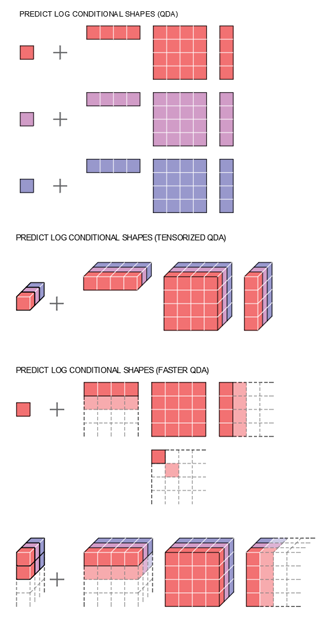

### *2.1.1 Punto 1*

In [ ]:
class FasterQDA(TensorizedQDA):
    def _predict_log_conditionals(self, X, debug):
        unbiased_X = X - self.tensor_means # (k, n, m)

        inner_prod = unbiased_X.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_X # shape: (k, m, m)

        if debug:
          print((
              "\nInner product between:\n"
              f"- unbiased X tensor transposed (shape: {unbiased_X.transpose(0,2,1).shape})\n"
              f"- inverse of cov matrix tensor (shape: {self.tensor_inv_cov.shape})\n"
              f"- unbiased X tensor (shape: {unbiased_X.shape})\n"
              f"shape: {inner_prod.shape}\n"
              ))

        inner_prod_diagonal = np.diagonal(inner_prod, axis1=1, axis2=2) # shape: (k, m)

        log_likelihood_constant = np.log(det(self.tensor_inv_cov)).reshape(3, 1) # add dimension to allow broadcasting

        return 0.5 * log_likelihood_constant - 0.5 * inner_prod_diagonal # shape: (k, m)

    def predict(self, X, debug=False):
        log_a_priori_reshaped = self.log_a_priori.reshape(3, 1) # add dimension to allow broadcasting

        # We dont need _predict_one method anymore. Now we predict all at once!
        encoded_y_hat = np.argmax(log_a_priori_reshaped + self._predict_log_conditionals(X, debug), axis=0)
        y_hat = self.encoder.names[encoded_y_hat]

        return y_hat.reshape(1,-1)

### *2.1.2 Punto 2*

In [ ]:
qda = QDA()
qda.fit(train_x, train_y)

ten_qda = TensorizedQDA ()
ten_qda.fit(train_x, train_y)

fast_qda = FasterQDA()
fast_qda.fit(train_x, train_y)

In [ ]:
%%timeit
qda.predict(test_x)

4.68 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
ten_qda.predict(test_x)

1.78 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit
fast_qda.predict(test_x)

63.6 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# Verify that we obtained the same predictions that we obtained previously.
(fast_qda.predict(test_x) == ten_qda.predict(test_x)).all()

True

### *2.1.3 Punto 3*

In [ ]:
fast_qda.predict(test_x, debug=True);


Inner product between:
- unbiased X tensor transposed (shape: (3, 60, 4))
- inverse of cov matrix tensor (shape: (3, 4, 4))
- unbiased X tensor (shape: (3, 4, 60))
shape: (3, 60, 60)



### *2.1.4 Punto 4: "Demostración"*

Sean
$$
A \in \mathbb{R}^{m \times n}, B \in \mathbb{R}^{n \times m}
$$
<br>
- Por definición del producto de Hadamard de matrices tenemos:
$$
(A \odot B^T)_{ij} = A_{ij}B^T_{ij} = A_{ij}B_{ji}
$$
Cuya suma a través de columnas para un vector fila $i$ es:
$$
  \sum_{cols} (A \odot B^T)_{i.} = \sum_{j=1}^{n}A_{ij}B^T_{ij} = \sum_{j=1}^{n}A_{ij}B_{ji}
$$
Podemos generalizar entonces a todas las filas:
$$
\sum_{cols} A \odot B^T = {[\sum_{j=1}^{n}A_{1j}B_{j1},\sum_{j=1}^{n}A_{2j}B_{j2},...,\sum_{j=1}^{n}A_{mj}B_{jm}]^T} _{(1)}
$$
<br>
- Por definición del producto de matrices:
$$
(A \cdot B)_{ij} = \sum_{r=1}^{n}A_{ir}B_{rj}
$$
Dónde cada elemento $i$ de la diagonal es:
$$
(A \cdot B)_{ii} = \sum_{r=1}^{n}A_{ir}B_{ri}
$$
Por lo cual:
$$
diag(A \cdot B) = {[\sum_{j=1}^{n}A_{1j}B_{j1},\sum_{j=1}^{n}A_{2j}B_{j2},...,\sum_{j=1}^{n}A_{mj}B_{jm}]^T} _{(2)}
$$
<br>
- Comparando $(1)$ y $(2)$, obtenemos:

$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$


###*2.1.5 Punto 5*

In [ ]:
class FasterQDA(TensorizedQDA):
    def _predict_log_conditionals(self, X, debug):
        unbiased_X = X - self.tensor_means # (k, n, m)

        # We obtain inner_prod_diagonal avoiding nxn matrix!
        first_inner_prod = unbiased_X.transpose(0,2,1) @ self.tensor_inv_cov # shape: (k, m, n)
        inner_prod_diagonal = np.sum(first_inner_prod * unbiased_X.transpose(0,2,1), axis=2) # shape: (3, 90)

        if debug:
          print((
              "\nInner product between:\n"
              f"- unbiased X tensor transposed (shape: {unbiased_X.transpose(0,2,1).shape})\n"
              f"- inverse of cov matrix tensor (shape: {self.tensor_inv_cov.shape})\n"
              f"shape: {first_inner_prod.shape}\n"
              "Sum of Hadamard product between:"
              f"- inner product obtained previously (shape: {unbiased_X.shape})\n"
              f"- unbiased X tensor trasnposed (shape: {unbiased_X.shape})\n"
              f"shape: {inner_prod_diagonal.shape}\n"
              ))

        log_likelihood_constant = np.log(det(self.tensor_inv_cov)).reshape(3, 1) # add dimension to allow broadcasting

        return 0.5 * log_likelihood_constant - 0.5 * inner_prod_diagonal # shape: (k, m)

    def predict(self, X, debug=False):
        log_a_priori_reshaped = self.log_a_priori.reshape(3, 1) # add dimension to allow broadcasting

        # We dont need _predict_one method anymore. Now we predict all at once!
        encoded_y_hat = np.argmax(log_a_priori_reshaped + self._predict_log_conditionals(X, debug), axis=0)
        y_hat = self.encoder.names[encoded_y_hat]

        return y_hat.reshape(1,-1)

In [ ]:
fast_qda = FasterQDA()
fast_qda.fit(train_x, train_y)

In [ ]:
%%timeit
fast_qda.predict(test_x)

47.4 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Se observan mejoras no significativas en esta prueba de la nueva implementación de FasterQDA para n=60 observaciones. Sin embargo, a medida que aumente el número de observaciones, la ventaja de no computar la matriz $n \times n$ se volverá mucho más relevante.

##***2.2 LDA***

### *2.2.1 Punto 1*

LDA - como referencia

```Python
class LDA(BaseBayesianClassifier):
    def _fit_params(self, X, y):
        # Computing the means of each class
        self.means = [X[:, y.flatten() == idx].mean(axis=1, keepdims=True)
                      for idx in range(len(self.log_a_priori))]

        # Computing the covariance matrices for each class
        covariances = [np.cov(X[:, y.flatten() == idx], bias=True)
                       for idx in range(len(self.log_a_priori))]

        # Computing the clustered covariance matrix as a weighted average
        # for the relative frequencies of the class
        freqs = np.bincount(y.flatten().astype(int)) / y.size
        pooled_cov = sum([cov * freq for cov, freq in zip(covariances, freqs)])

        # Computing the inverse of the clustered covariance matrix.
        self.inv_pooled_cov = inv(pooled_cov)

    def _predict_log_conditional(self, x, class_idx):
        # Computing the logarithm of the conditional probability P(x|G=class_idx)
        # For LDA, it's assumed that all the classes share the same coavariance matrix
        unbiased_x = x - 0.5*self.means[class_idx]
        return self.means[class_idx].T @ self.inv_pooled_cov @ unbiased_x
```

In [ ]:
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        # ask plain LDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov_pooled = self.inv_pooled_cov #No es necesario el stack, ya que solo tenemos una matriz inversa agrupada a diferencia de QDA
        self.tensor_means = np.stack(self.means)

        #Precómputo de mu^T * Sigma^{-1}
        self.precomp = self.tensor_means.transpose(0,2,1) @ self.tensor_inv_cov_pooled

    def _predict_log_conditionals(self,x):
        unbiased_x = x - 0.5*self.tensor_means
        calc = self.precomp @ unbiased_x
        return calc.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        max_class = np.argmax(self.log_a_priori + self._predict_log_conditionals(x))
        return max_class

In [ ]:
# Iniciamos los modelos:
lda     = LDA()
ten_lda =  TensorizedLDA()

In [ ]:
# Obtenemos los datos del primer dataset: Iris
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

In [ ]:
# Medimos el tiempo de LDA
%%timeit

lda.fit(train_x, train_y)
lda.predict(test_x)


4.5 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Medimos el tiempo de LDA Tensorizado
%%timeit

ten_lda.fit(train_x, train_y)
ten_lda.predict(test_x)

2.14 ms ± 95.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Comparamos con LDA

def accuracy_score(y_true, y_pred):
  return (y_true == y_pred).mean()

ten_lda_acc = accuracy_score(test_y, ten_lda.predict(test_x))
lda_acc = accuracy_score(test_y, lda.predict(test_x))

print(f"Tensorized LDA Accuracy: {ten_lda_acc}")
print(f"LDA Accuracy: {lda_acc}")

Tensorized LDA Accuracy: 0.9833333333333333
LDA Accuracy: 0.9833333333333333


In [ ]:
# Repetimos con el dataset Penguins:
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Medimos el tiempo de LDA
%%timeit

lda.fit(train_x, train_y)
lda.predict(test_x)


10.1 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Medimos el tiempo de LDA Tensorizado
%%timeit

ten_lda.fit(train_x, train_y)
ten_lda.predict(test_x)

4.15 ms ± 712 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Comparamos con LDA

def accuracy_score(y_true, y_pred):
  return (y_true == y_pred).mean()

ten_lda_acc = accuracy_score(test_y, ten_lda.predict(test_x))
lda_acc = accuracy_score(test_y, lda.predict(test_x))
matches = (ten_lda.predict(test_x) == lda.predict(test_x)).all()

print(f"Tensorized LDA Accuracy: {ten_lda_acc}")
print(f"LDA Accuracy: {lda_acc}")
print(f"Matches? {matches}")

Tensorized LDA Accuracy: 0.9927007299270073
LDA Accuracy: 0.9927007299270073
Matches? True


#### Respuesta:
El método LDA Tensorizado es más rápido que el LDA implementado antes y con un nivel de accuracy similar.

### *2.2.2 Punto 2*

LDA Tensorized - Referencia

```Python
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        # ask plain LDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov_pooled = self.inv_pooled_cov
        #No es necesario el stack, ya que solo tenemos una
        #matriz inversa agrupada a diferencia de QDA
        self.tensor_means = np.stack(self.means)

        #Precómputo de mu^T * Sigma^{-1}
        self.precomp = self.tensor_means.transpose(0,2,1) @ self.tensor_inv_cov_pooled

    def _predict_log_conditionals(self,x):
        unbiased_x = x - 0.5*self.tensor_means
        calc = self.precomp @ unbiased_x
        return calc.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        max_class = np.argmax(self.log_a_priori + self._predict_log_conditionals(x))
        return max_class
  ```

In [ ]:
class FasterLDA(TensorizedLDA):
  #Based on FasterQDA with diagonal

    def _predict_log_conditionals(self,x):
      unbiased_x = x - 0.5*self.tensor_means
      calc = self.precomp @ unbiased_x
      return calc.squeeze(axis=1)

    def predict(self, X):

      log_priors_reshaped = self.log_a_priori.reshape(-1, 1)  # Añadir una dimensión para broadcasting

      # We dont need _predict_one method anymore. Now we predict all at once!
      encoded_y_hat = np.argmax(log_priors_reshaped + self._predict_log_conditionals(X), axis=0)
      y_hat = self.encoder.names[encoded_y_hat]

      # return prediction as a row vector (matching y)
      return y_hat.reshape(1,-1)

In [ ]:
# Iniciamos los modelos:
lda     = LDA()
ten_lda =  TensorizedLDA()
faster_lda = FasterLDA()

In [ ]:
# Obtenemos los datos del primer dataset: Iris
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

In [ ]:
# Medimos el tiempo de LDA
%%timeit

lda.fit(train_x, train_y)
lda.predict(test_x)

9.27 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Medimos el tiempo de Tensorized LDA
%%timeit

ten_lda.fit(train_x, train_y)
ten_lda.predict(test_x)

2.14 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Medimos el tiempo de FasterLDA
%%timeit

faster_lda.fit(train_x, train_y)
faster_lda.predict(test_x)

779 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# Comparamos con LDA y Tensorized LDA

def accuracy_score(y_true, y_pred):
  return (y_true == y_pred).mean()

lda_acc = accuracy_score(test_y, lda.predict(test_x))
print(f"LDA Accuracy: {lda_acc}")
ten_lda_acc = accuracy_score(test_y, ten_lda.predict(test_x))
print(f"Tensorized LDA Accuracy: {ten_lda_acc}")
faster_lda_acc = accuracy_score(test_y, faster_lda.predict(test_x))
print(f"Faster LDA Accuracy: {faster_lda_acc}")

matches = (lda.predict(test_x) == faster_lda.predict(test_x)).all()
print(f"Matches? {matches}")

LDA Accuracy: 0.9833333333333333
Tensorized LDA Accuracy: 0.9833333333333333
Faster LDA Accuracy: 0.9833333333333333
Matches? True


### Respuesta:
Se puede observar que FasterLDA es efectivamente más rápido que las otras dos versiones (LDA y TensorizedLDA).

# 3 Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

### *3.1 Punto 1*

Para LDA se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Esto nos da la función de densidad:

Esto nos da que la función de densidad para una clase $j$ es:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda:

$$
\log{f_j(x)} = \log{(\frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)})}
$$

> Recordando propiedades de los logaritmos:
<br>
> $ \log(a.b) = \log(a) + \log(b) $

$$
\log{f_j(x)} = \log{(\frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma|^\frac{1}{2}})} - \frac{1}{2}(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)
$$

Podemos simplificar y agrupar las constantes, ya que son iguales para todas las clases. Es decir, aquellos términos que no dependan de $x$, por ejemplo: $ \log{(\frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma|^\frac{1}{2}})} $. Entonces nos queda:

$$
\log{f_j(x)} = {- \frac{1}{2}(x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C}  _{(1)}
$$

Donde C es una constante.

Ahora consideremos el término: $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$


Este se puede expandir de la siguiente forma. Considerando la propiedad distributiva de matrices transpuestas $(A+B)^T = A^T + B^T $, tenemos:

$(x-\mu_j)^T \Sigma^{-1} (x- \mu_j) = (x^T-\mu_j^T) \Sigma^{-1} (x- \mu_j)
$

Ahora, por propiedad distributiva de la multiplicación de matrices, nos queda:

$  = x^T \Sigma^{-1}(x- \mu_j) - \mu_j^T \Sigma^{-1}(x- \mu_j) $

$  = {(x^T \Sigma^{-1} x) - (x^T \Sigma^{-1}\mu_j) - (\mu_j^T \Sigma^{-1} x) + (\mu_j^T \Sigma^{-1} \mu_j)} _{(2)} $

Nótese que $x$ y $\mu_j$ son vectores columna y $\Sigma^{-1}$ es una matriz simétrica. Por esta razón, la multiplicación del término $x^T \Sigma^{-1}\mu_j$ resulta en un escalar (vector fila por matriz por vector columna). La transpuesta de un escalar es el mismo escalar y por lo tanto:

$x^T \Sigma^{-1}\mu_j = (x^T \Sigma^{-1}\mu_j)^T$


Ahora, considerando la propiedad de la transposición de un producto de matrices: $(ABC)^T = C^T B^T A^T$, podemos aplicar que:

$(x^T \Sigma^{-1}\mu_j)^T = \mu_j^T (\Sigma^{-1})^T (x^T)^T $

Además, la transpuesta de una matriz simétrica es ella misma, y $(A^T)^T = A$. Entonces:

$ {x^T \Sigma^{-1}\mu_j = \mu_j^T (\Sigma^{-1})^T (x^T)^T = \mu_j^T \Sigma^{-1} x} _{(3)}
$

Reemplazando (3) en (2), tenemos:

$ = {(x^T \Sigma^{-1} x) - (\mu_j^T \Sigma^{-1} x) - (\mu_j^T \Sigma^{-1} x) + (\mu_j^T \Sigma^{-1} \mu_j)}  $

$ (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) =  {(x^T \Sigma^{-1} x) - 2(\mu_j^T \Sigma^{-1} x) + (\mu_j^T \Sigma^{-1} \mu_j)} _{(4)}$

Esto nos quedaría entonces si volvemos a (1) y reemplazamos por (4):

$$
\log{f_j(x)} = {- \frac{1}{2} [(x^T \Sigma^{-1} x) - 2(\mu_j^T \Sigma^{-1} x) + (\mu_j^T \Sigma^{-1} \mu_j)]  + C}
$$

Nótese que el término $ (x^T \Sigma^{-1} x) $ no depende de la clase $j$ (es igual para todas las clases) y no afecta a la maximización, por lo que podemos agregarlo a la constante.

> Nota: Este término corresponde a la forma cuadrática y es una diferencia clave en comparación con QDA, en dónde no se puede simplificar ni agregar a la constante ya que sí depende de la clase e influye en la maximización.

$$
\log{f_j(x)} = {- \frac{1}{2} [- 2(\mu_j^T \Sigma^{-1} x) + (\mu_j^T \Sigma^{-1} \mu_j)]  + C'}
$$

Por propiedad distributiva:

$$
\log{f_j(x)} = {(\mu_j^T \Sigma^{-1} x) - \frac{1}{2} (\mu_j^T \Sigma^{-1} \mu_j)  + C'}
$$

Por último, sacamos como factor comun a $ (\mu_j^T \Sigma^{-1}) $ y nos queda:

$$
\log{f_j(x)} = {(\mu_j^T \Sigma^{-1}) (x - \frac{1}{2} \mu_j)  + C'}
$$

-------

### *3.2 Punto 2*
El logaritmo de la función de densidad de QDA y LDA a maximizar nos permite entender la razón detrás del término "quadratic" y "linear" en el nombre de ambos modelos respectivamente.

En el caso de QDA, con logaritmo de pdf a maximizar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observamos que $x$ aparece en la forma cuadrática $(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)$. Esto nos indica que al momento de buscar una función para realizar el borde de decisión con respecto al input $x$, este va a tomar forma cuadrática.

Por otro lado, en el caso de LDA, con logaritmo de pdf a maximizar:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

Observamos que $x$ aparece en forma linear $\mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j)$. Por lo tanto, al buscar una función para realizar el borde de decisión con respecto al input $x$, este va a tomar forma linear.

### *3.3 Punto 3*

La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) - 0.5 * unbiased_x.T @ inv_cov @ unbiased_x` a diferencia del apartado teórico, dónde la función a maximizar es:

$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Como se explicó en el apartado teórico, podemos aplicar logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

Al comparar la implementación en código con la función descrita en el apartado teórico, vemos en primer lugar que no se incorpora la constante $C$ mencionada en el párrafo anterior.

Además vemos que en la transformación de $f_j(x)$ a $\log{f_j(x)}$, la expresión:

$$
\frac{1}{|\Sigma_j|^\frac{1}{2}} = |\Sigma_j|^{-\frac{1}{2}}
$$

se desarrolló como:

$$
-\frac{1}{2}\log |\Sigma_j|
$$

mientras que en el código se desarrolló como:

$$
\frac{1}{2}\log |\Sigma_j^{-1}|
$$

es decir `0.5*np.log(det(inv_cov))`.

Por otro lado, el segundo término de la función aparece en el código como representación de su expresión matemática `0.5 * unbiased_x.T @ inv_cov @ unbiased_x`.

# 4 Ejercicio teórico



Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

***Resolución***

---

![Mathematics for machine learning - M. Disenroth - Figure 5.8](resources/Mathematics%20for%20machine%20learning%20-%20M.%20Disenroth%20-%20Figure%205.8.PNG "Mathematics for machine learning - M. Disenroth - Figure 5.8")

## ***Marco teórico***

Partiendo de las siguientes definiciones:

- $f_0 := \bar{x}$
- $f_i := \sigma_i (A_{i-1} \cdot f_i + b_i), i=1,...,k$
- ${\frac{\partial L}{\partial \theta_i}} = {\frac{\partial L}{\partial f_k}} \cdot {\frac{\partial f_k}{\partial f_{k-1}}} \cdots {\frac{\partial f_{i+2}}{\partial f_{i+1}}} \cdot {\frac{\partial f_{i+1}}{\partial \theta_i}}$

Para la siguiente función de activación $ \sigma(z) =  \frac{\mathrm{1}}{\mathrm{1} + e^{-z}} $ y la siguiente función de costo $ L = \frac{1}{2}(f_k(\theta, x)-y)^2 $ se obtienen las siguiente gradientes para cada capa:

**CAPA K:**

${\frac{\partial L}{\partial \theta_{k-1}}} = {\frac{\partial L}{\partial f_k}} \cdot {\frac{\partial f_k}{\partial \theta_{k-1}}}$, donde:
- ${\frac{\partial L}{\partial f_k}}$ es como varía el error con respecto a la función $f_k$. Como la función de error está compuesta por la función de activación $\sigma_z$, entonces aplicando la regla de la cadena tenemos que:

$$
{\frac{\partial L}{\partial f_k}} = \underbrace{{\frac{\partial L}{\partial \sigma_k}}}_{\substack{(f_k - y)}} \cdot \underbrace{{\frac{\partial \sigma_k}{\partial f_k}}}_{\substack{f_k \cdot (1 - f_k)}} \Rightarrow {\frac{\partial L}{\partial f_k}} = (f_k - y) \cdot f_k \cdot (1 - f_k)
$$

- ${\frac{\partial f_k}{\partial \theta_{k-1}}}$ es como varía la función $f_k$ con respecto a los parámetros (pesos). En este caso: $\theta = \left\{ \overset{w^{(1)}}{A_0}, \overset{b^{(1)}}{b_0}, \overset{w^{(2)}}{A_1}, \overset{b^{(2)}}{A_1} \right\}$.

> ${\color{Grey}{Nota: \theta = \left\{ A_0, b_0, ..., A_{k-1}, b_{k-1}\right\}}}$

$\Rightarrow {\frac{\partial L}{\partial \theta_{k-1}}} = \left [ {\frac{\partial f_k}{\partial A_{k-1}}}, {\frac{\partial f_k}{\partial b_{k-1}}} \right ]$, como ${\frac{\partial f_k}{\partial A_{k-1}}} = f_{k-1}$ y ${\frac{\partial f_k}{\partial b_{k-1}}} = 1$ $\Rightarrow$ $\left [ f_{k-1}, 1 \right ]$

Por lo tanto, si llamamos $\delta^k = (f_{k} - y) \cdot f_k \cdot (1 - f_k)$ entonces el gradiente de la *capa k* es:

$$
{\frac{\partial L}{\partial \theta_{k-1}}} = \boxed{\nabla_k = \left [ \delta^k \cdot f_{k-1}, \delta^k \right ]}
$$

**CAPA K-1:**

Para esta capa es necesario calcular únicamente como varía la salida de la capa anterior con respecto a ésta. Partiendo de:

$$
{\frac{\partial L}{\partial \theta_{k-2}}} = {\frac{\partial L}{\partial f_k}} \cdot \underbrace{{\frac{\partial f_k}{\partial f_{k-1}}}}_{\substack{\text{Variación} \\ \text{entre capas}}} \cdot {\frac{\partial f_{k-1}}{\partial \theta_{k-2}}}
$$

Tenemos que calcular únicamente ${\frac{\partial f_k}{\partial f_{k-1}}}$ ya que ${\frac{\partial L}{\partial f_k}} = \delta^k$ y ${\frac{\partial f_{k-1}}{\partial \theta_{k-2}}} = \left [ f_{k-2}, 1 \right ]$

Entonces, aplicando la regla de la cadena (ya que $f$ es una composición de la función de activación) tenemos que:

$$
{\frac{\partial f_k}{\partial f_{k-1}}} = \underbrace{{\frac{\partial f_k}{\partial \sigma_{k-1}}}}_{\substack{A_{k-1}}} \cdot \underbrace{{\frac{\partial \sigma_{k-1}}{\partial f_{k-1}}}}_{\substack{(f_{k-1} - y) \cdot f_k \cdot (1 - f_k)}}
$$

Si llamamos $\delta^{k-1} = \delta^k \cdot f_{k-1} \cdot (1 - f_{k-1}) \cdot A_{k-1}$, entonces tenemos que el gradiente de la *capa k-1* es:

$$
{\frac{\partial L}{\partial \theta_{k-2}}} = \boxed{\nabla_{k-1} = \left [ \delta^{k-1} \cdot f_{k-2}, \delta^{k-1} \right ]}
$$

## ***Ejercicio***

> Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $L(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

![Neural Net](resources/Neural%20net.PNG)

- $f_0 =$
$ \begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix} $

- $f_1 = \sigma(w^{(1)} \cdot f_0 + b^{(1)})$

$\Rightarrow$ $f_1=$
$ \begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix} $
$ \begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix} $
$+$
$ \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix} $
$\Rightarrow$ $f_1 = \sigma$
$ \begin{pmatrix}
1.98 \\
3.02 \\
2.17
\end{pmatrix}  $

$\therefore \boxed{f_1=
\begin{pmatrix}
0.88 \\
0.95 \\
0.90
\end{pmatrix}
}$

- $f_1 = \sigma(w^{(2)} \cdot f_1 + b^{(2)})$

$\Rightarrow$ $f_2 =$
$ \begin{pmatrix}
-0.4 \\
0.2 \\
-0.5
\end{pmatrix}^T $
$\begin{pmatrix}
0.88 \\
0.95 \\
0.90
\end{pmatrix}$
$+$ $0.7$
$\Rightarrow$ $f_2=\sigma(0.09)$

$\therefore \boxed{f_2 = 0.52}$

> ${\color{Gray}{Nota: L = \frac{1}{2}(0.52-5)^2 = 10.03}}$

**CAPA 2:**

$\nabla_2 L = \left [ \delta^{(2)} \cdot f_{1}, \delta^{(2)} \right ]$, donde $\delta^2 = (f_2 - y) \cdot f_2 \cdot (1 - f_2)$ $\Rightarrow$ $\delta^2 = (0.52 - 5) \cdot 0.52 \cdot (1 - 0.52)$ $\Rightarrow$ $\delta^{(2)} = -1.11$

$$
\therefore \nabla_2 L = \left [ (-1.11)
\begin{pmatrix}
0.88 \\
0.95 \\
0.90
\end{pmatrix}
, -1.11
\right ]
\Rightarrow \boxed{\nabla_2 L = \left [
\underbrace{
\begin{pmatrix}
-0.98 \\
-1.05 \\
1.00
\end{pmatrix}
}_{\substack{w^2}}
,
\underbrace{-1.11}_{\substack{b^2}}
\right ]
}
$$

**CAPA 1:**

$\nabla_2 L = \left [ \delta^{(1)} \cdot f_{0}, \delta^{(1)} \right ]$, donde $\delta^1 = \delta^2 \cdot f_1 \cdot (1 - f_1) \cdot \underbrace{A_1}_{\substack{w^2}}$

$\Rightarrow \delta^{(1)} = (-1.11)$
$\begin{pmatrix}
0.88 \\
0.95 \\
0.90
\end{pmatrix}$
$\left [ 1 -
\begin{pmatrix}
0.88 \\
0.95 \\
0.90
\end{pmatrix}
\right ]$
$\begin{pmatrix}
-0.4 \\
0.2 \\
-0.5
\end{pmatrix}$
$=$
$ \begin{pmatrix}
0.11 \\
-0.05 \\
0.13
\end{pmatrix} $

$$
\therefore \nabla_1 L = \left [
\begin{pmatrix}
0.11 \\
-0.05 \\
0.13
\end{pmatrix}
\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}^T
,
\begin{pmatrix}
0.11 \\
-0.05 \\
0.13
\end{pmatrix}
\right ]
\Rightarrow \boxed{\nabla_1 L = \left [
\underbrace{
\begin{pmatrix}
0.20 & -0.37 \\
-0.09 & 0.17 \\
0.23 & 0.44
\end{pmatrix}
}_{\substack{w^1}}
,
\underbrace{
\begin{pmatrix}
0.11 \\
-0.05 \\
0.13
\end{pmatrix}
}_{\substack{b^1}}
\right ]
}
$$

# 5 Preguntas en el código


Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas.